In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0078

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - loss: 0.0053
Average validation loss: 0.7241169214248657
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - loss: 0.0053 - val_loss: 0.7241
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - loss: 0.0033 - val_loss: 0.7241
Average validation loss: 0.6000972390174866
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - loss: 0.0033 - val_loss: 0.6621
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 555ms/step - loss: 0.0023 - val_loss: 0.6621
Average validation loss: 0.5403643846511841
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 567ms/step - loss: 0.0023 - val_loss: 0.6215
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 774ms/step - loss: 9.2979e-07
Average validation loss: 0.1199917383491993
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 786ms/step - loss: 9.2979e-07 - val_loss: 0.1200
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 776ms/step - loss: 8.7825e-07 - val_loss: 0.1200
Average validation loss: 0.05837315134704113
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 788ms/step - loss: 8.7825e-07 - val_loss: 0.0892
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 776ms/step - loss: 8.3262e-07 - val_loss: 0.0892
Average validation loss: 0.142463531345129
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 788ms/step - loss: 8.3262e-07 - val_loss: 0.1069
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 773ms/step - loss: 8.3246e-07 - val_loss: 0.1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 783ms/step - loss: 5.3036e-07
Average validation loss: 0.05545681963364283
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 794ms/step - loss: 5.3036e-07 - val_loss: 0.0555
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 773ms/step - loss: 4.9671e-07 - val_loss: 0.0555
Average validation loss: 0.03486991332223018
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 785ms/step - loss: 4.9671e-07 - val_loss: 0.0452
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 775ms/step - loss: 4.7144e-07 - val_loss: 0.0452
Average validation loss: 0.03931479218105475
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 785ms/step - loss: 4.7144e-07 - val_loss: 0.0432
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 774ms/step - loss: 4.6950e-

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 773ms/step - loss: 2.9667e-07
Average validation loss: 0.0527678900398314
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 785ms/step - loss: 2.9667e-07 - val_loss: 0.0528
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 772ms/step - loss: 2.7407e-07 - val_loss: 0.0528
Average validation loss: 0.03410731418989599
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 782ms/step - loss: 2.7407e-07 - val_loss: 0.0434
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 776ms/step - loss: 2.5825e-07 - val_loss: 0.0434
Average validation loss: 0.03236955776810646
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 786ms/step - loss: 2.5825e-07 - val_loss: 0.0397
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weig

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 778ms/step - loss: 2.1204e-07
Average validation loss: 0.02339016068726778
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 789ms/step - loss: 2.1204e-07 - val_loss: 0.0234
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - loss: 2.1440e-07 - val_loss: 0.0234
Average validation loss: 0.031880294997245075
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 787ms/step - loss: 2.1440e-07 - val_loss: 0.0276
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 776ms/step - loss: 2.1418e-07 - val_loss: 0.0276
Average validation loss: 0.02375449873507023
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 787ms/step - loss: 2.1418e-07 - val_loss: 0.0263
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - loss: 2.0282e-07 - val_loss: 0.0263
Average validation loss: 0.02559070345014334
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 784ms/step - loss: 2.0282e-07 - val_loss: 0.0262
Epoch 5/

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 773ms/step - loss: 2.9352e-07
Average validation loss: 0.03138719592243433
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 783ms/step - loss: 2.9352e-07 - val_loss: 0.0314
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 772ms/step - loss: 2.7257e-07 - val_loss: 0.0314
Average validation loss: 0.0206874826302131
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 782ms/step - loss: 2.7257e-07 - val_loss: 0.0260
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 2.5041e-07 - val_loss: 0.0260
Average validation loss: 0.017970913788303733
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 2.5041e-07 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\wei

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 790ms/step - loss: 2.2632e-07
Average validation loss: 0.03805123306810856
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 801ms/step - loss: 2.2632e-07 - val_loss: 0.0381
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 774ms/step - loss: 2.2010e-07 - val_loss: 0.0381
Average validation loss: 0.04696472808718681
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - loss: 2.2010e-07 - val_loss: 0.0425
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 774ms/step - loss: 1.9936e-07 - val_loss: 0.0425
Average validation loss: 0.03858715780079365
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 783ms/step - loss: 1.9936e-07 - val_loss: 0.0412
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 775ms/step - loss: 1.9186e-07 - val_loss: 0.0412
Average validation loss: 0.04229631526395679
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 784ms/step - loss: 1.9186e-07 - val_loss: 0.0415
Epoch 5

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 778ms/step - loss: 2.8248e-07
Average validation loss: 0.020554439319918554
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 2.8248e-07 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 774ms/step - loss: 2.3265e-07 - val_loss: 0.0206
Average validation loss: 0.0196663059371834
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 783ms/step - loss: 2.3265e-07 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 772ms/step - loss: 1.9629e-07 - val_loss: 0.0201
Average validation loss: 0.021334756243353088
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 781ms/step - loss: 1.9629e-07 - val_loss: 0.0205
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 775ms/step - loss: 1.7

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 780ms/step - loss: 1.7485e-07
Average validation loss: 0.021954996710909263
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 789ms/step - loss: 1.7485e-07 - val_loss: 0.0220
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 775ms/step - loss: 1.4082e-07 - val_loss: 0.0220
Average validation loss: 0.027117671578058174
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 784ms/step - loss: 1.4082e-07 - val_loss: 0.0245
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 776ms/step - loss: 1.2666e-07 - val_loss: 0.0245
Average validation loss: 0.024886570205645903
56/56 ━━━━━━━━━━━━━━━━━━━━ 132s 785ms/step - loss: 1.2666e-07 - val_loss: 0.0247
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 176s 776ms/step - loss: 1.1292e-07 - val_loss: 0.0247
Average validation loss: 0.02735552640764841
56/56 ━━━━━━━━━━━━━━━━━━━━ 176s 788ms/step - loss: 1.1292e-07 - val_loss: 0.0253
Ep

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 778ms/step - loss: 9.1649e-08
Average validation loss: 0.02549752575578168
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 789ms/step - loss: 9.1649e-08 - val_loss: 0.0255
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 775ms/step - loss: 7.9585e-08 - val_loss: 0.0255
Average validation loss: 0.03157475305488333
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 783ms/step - loss: 7.9585e-08 - val_loss: 0.0285
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 777ms/step - loss: 6.8943e-08 - val_loss: 0.0285
Average validation loss: 0.03302385803544894
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 788ms/step - loss: 6.8943e-08 - val_loss: 0.0300
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 775ms/step - loss: 6.3959e-08 - val_loss: 0.0300
Average validation loss: 0.0366790636908263
64/64 ━━━━━━━━━━━━━━━━━━━━ 201s 787ms/step - loss: 6.3959e-08 - val_loss: 0.0317
Epoc

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 776ms/step - loss: 7.3348e-08
Average validation loss: 0.034972453541639775
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 785ms/step - loss: 7.3348e-08 - val_loss: 0.0350
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - loss: 6.3504e-08 - val_loss: 0.0350
Average validation loss: 0.030978721773458853
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 785ms/step - loss: 6.3504e-08 - val_loss: 0.0330
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 777ms/step - loss: 5.5722e-08 - val_loss: 0.0330
Average validation loss: 0.03348090365115139
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 785ms/step - loss: 5.5722e-08 - val_loss: 0.0331
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 225s 776ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 775ms/step - loss: 8.4601e-08
Average validation loss: 0.03466894901357591
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 783ms/step - loss: 8.4601e-08 - val_loss: 0.0347
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 776ms/step - loss: 6.5754e-08 - val_loss: 0.0347
Average validation loss: 0.03333879695273936
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 784ms/step - loss: 6.5754e-08 - val_loss: 0.0340
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 776ms/step - loss: 5.6456e-08 - val_loss: 0.0340
Average validation loss: 0.03733086159918457
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 786ms/step - loss: 5.6456e-08 - val_loss: 0.0351
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 250s 775ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 775ms/step - loss: 1.7058e-07
Average validation loss: 0.03927484274997065
96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 785ms/step - loss: 1.7058e-07 - val_loss: 0.0393
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 774ms/step - loss: 1.6478e-07 - val_loss: 0.0393
Average validation loss: 0.044526341875704624
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 782ms/step - loss: 1.6478e-07 - val_loss: 0.0419
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 774ms/step - loss: 1.4507e-07 - val_loss: 0.0419
Average validation loss: 0.04318747933333119
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 785ms/step - loss: 1.4507e-07 - val_loss: 0.0423
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 300s 773ms/step - loss: 1.2687e-07 - val_loss: 0.0423
Average validation loss: 0.03521532790424923
96/96 ━━━━━━━━━━━━━━━━━━━━ 301s 783ms/step - loss: 1.2687e-07 - val_loss: 0.0406
S

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 776ms/step - loss: 1.9619e-07
Average validation loss: 0.023532818413029115
120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 1.9619e-07 - val_loss: 0.0235
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 188s 776ms/step - loss: 1.7151e-07 - val_loss: 0.0235
Average validation loss: 0.03193056494928896
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 788ms/step - loss: 1.7151e-07 - val_loss: 0.0277
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 282s 775ms/step - loss: 1.4844e-07 - val_loss: 0.0277
Average validation loss: 0.022120031431162108
120/120 ━━━━━━━━━━━━━━━━━━━━ 283s 783ms/step - loss: 1.4844e-07 - val_loss: 0.0259
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 376s 775

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - loss: 1.5666e-07
Average validation loss: 0.036294252634737255
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 785ms/step - loss: 1.5666e-07 - val_loss: 0.0363
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 775ms/step - loss: 1.5532e-07 - val_loss: 0.0363
Average validation loss: 0.04728781553179336
144/144 ━━━━━━━━━━━━━━━━━━━━ 226s 783ms/step - loss: 1.5532e-07 - val_loss: 0.0418
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 337s 773ms/step - loss: 1.4477e-07 - val_loss: 0.0418
Average validation loss: 0.06612468734399751
144/144 ━━━━━━━━━━━━━━━━━━━━ 339s 782ms/step - loss: 1.4477e-07 - val_loss: 0.0499
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 450s 773ms/step - loss: 1.3125e-07 - val_loss: 0.0499
Average validation loss: 0.051881341981546335
144/144 ━━━━━━━━━━━━━━━━━━━━ 452s 786ms/step - loss: 1.3125e-07 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 773ms/step - loss: 1.1127e-07
Average validation loss: 0.02522288039617706
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 781ms/step - loss: 1.1127e-07 - val_loss: 0.0252
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 249s 773ms/step - loss: 7.7612e-08 - val_loss: 0.0252
Average validation loss: 0.02480420610518195
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 781ms/step - loss: 7.7612e-08 - val_loss: 0.0250
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 374s 774ms/step - loss: 6.3897e-08 - val_loss: 0.0250
Average validation loss: 0.0245193071779795
160/160 ━━━━━━━━━━━━━━━━━━━━ 375s 783ms/step - loss: 6.3897e-08 - val_loss: 0.0248
Saved model weights to 'c:\天_11157065\git\Ripples

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 776ms/step - loss: 1.1398e-07
Average validation loss: 0.02395577365765348
200/200 ━━━━━━━━━━━━━━━━━━━━ 157s 786ms/step - loss: 1.1398e-07 - val_loss: 0.0240
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 773ms/step - loss: 8.9744e-08 - val_loss: 0.0240
Average validation loss: 0.02257900350545242
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 786ms/step - loss: 8.9744e-08 - val_loss: 0.0233
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 469s 774ms/step - loss: 7.6775e-08 - val_loss: 0.0233
Average validation loss: 0.018901883526705205
200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 782ms/step - loss: 7.6775e-08 - val_loss: 0.0218
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 186s 774ms/step - loss: 9.8516e-08
Average validation loss: 0.01931392897531623
240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 783ms/step - loss: 9.8516e-08 - val_loss: 0.0193
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 374s 774ms/step - loss: 7.7876e-08 - val_loss: 0.0193
Average validation loss: 0.024536002415698022
240/240 ━━━━━━━━━━━━━━━━━━━━ 376s 782ms/step - loss: 7.7876e-08 - val_loss: 0.0219
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 561s 773ms/step - loss: 6.7918e-08 - val_loss: 0.0219
Average validation loss: 0.021183544042287394
240/240 ━━━━━━━━━━━━━━━━━━━━ 563s 782ms/step - loss: 6.7918e-08 - val_loss: 0.0217
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 749s 772ms/step - loss: 6.0778e-08 - val_loss: 0.0217
Average validation loss: 0.021262125593299666
240/240 ━━━━━━━━━━━━━━━━━━━━ 751s 781ms/step - loss: 6.0778e-08 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1534863854199648, 0.062084438567981126, 0.036611288230245315, 0.0393066267715767, 0.025769308520480993, 0.020724114897505693, 0.028412035177461804, 0.032229488775289306, 0.04097758751695177, 0.05371580775885377, 0.046101631885394456, 0.04049331302731298, 0.03502000690088607, 0.05236371732668582, 0.038284212399629626, 0.029455751676376173, 0.027182005365572328, 0.02527525165221292]
std_val_losses =  [0.16556746894906138, 0.029601791528930204, 0.017434189186433056, 0.014226344245354393, 0.006498782171434448, 0.006900552478747329, 0.008676777989870762, 0.008155723562550798, 0.012662534625106614, 0.03094030076405813, 0.01072324773836411, 0.011065221639741236, 0.012014090907762343, 0.014204630695091864, 0.008555230373293725, 0.005401738531167594, 0.00540055353158795, 0.004280201585440107]


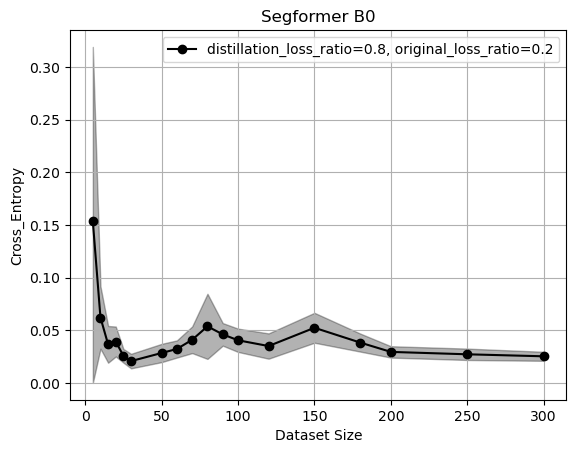

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()